In [32]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder


In [33]:
#Load the data
train= pd.read_csv('Train.csv')
test = pd.read_csv('Test (1).csv')
submission = pd.read_csv('SampleSubmission (2).csv')

We would like to join the two datasets together so that we can do feature engineering on both of them but we will split them before data model training to avoid data leakage. 

In [34]:
#check for null values
train.isnull().sum()

ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
target    0
dtype: int64

In [35]:
test.isnull().sum()

ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
dtype: int64

The datasets have no null values 

Since the column 'ID' is different in both datasets  we will have to drop and leave only the columns that are similar

In [36]:
train = train.drop(columns='ID')


In [37]:
test = test.drop(columns='ID')

In [38]:
#The target column is removed from the dataset and fitted into another data_frame
train_target = train['target']
train_copy = train.drop(columns='target')

In [39]:
train_copy.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU


In [40]:
#Combining the train and test dataset
combined_data = pd.concat([train_copy,test],ignore_index=True)
combined_data

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU
...,...,...,...,...,...,...,...,...
117161,2018-09-12,TU 0998,TUN,NCE,2018-09-12 14:15:00,2018-09-12 15.45.00,ATA,TU 320IMV
117162,2018-09-27,WKL 0000,TUN,TUN,2018-09-27 22:00:00,2018-09-28 01.00.00,SCH,TU 32AIMG
117163,2018-09-03,UG 1601,SJJ,TUN,2018-09-03 09:20:00,2018-09-03 11.10.00,SCH,TU CR9ISA
117164,2018-09-15,UG 0008,TUN,DJE,2018-09-15 14:30:00,2018-09-15 15.30.00,SCH,UG AT7LBD


In [41]:
#convert all the columns with dates to datetime format
combined_data['STD'] = pd.to_datetime(combined_data['STD'])
combined_data['STA'] = pd.to_datetime(combined_data['STA'], format='%Y-%m-%d %H.%M.%S')
combined_data['DATOP'] = pd.to_datetime(combined_data['DATOP'])

In [42]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117166 entries, 0 to 117165
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATOP   117166 non-null  datetime64[ns]
 1   FLTID   117166 non-null  object        
 2   DEPSTN  117166 non-null  object        
 3   ARRSTN  117166 non-null  object        
 4   STD     117166 non-null  datetime64[ns]
 5   STA     117166 non-null  datetime64[ns]
 6   STATUS  117166 non-null  object        
 7   AC      117166 non-null  object        
dtypes: datetime64[ns](3), object(5)
memory usage: 7.2+ MB


In [43]:
#Adding the duration column 
# Calculate the time difference between 'STD' and 'STA'
combined_data['Duration'] = combined_data['STA'] - combined_data['STD']
combined_data['Duration'] = combined_data['Duration'].dt.total_seconds()/ 60

In [44]:
min_value = combined_data['Duration'].min()

# Find the maximum value in the 'column_name' column
max_value = combined_data['Duration'].max()

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 10.0
Maximum value: 719520.0


In [45]:
combined_data.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,Duration
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,145.0
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,110.0
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,155.0
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,170.0
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,80.0


In [46]:
#Year', 'Month','Day', 'Dayofweek', 'Dayofyear',

# Extract hour, minute, day, month, and year from 'STD' and 'STA'
combined_data['Dep_hour'] =   combined_data['STD'].dt.hour
combined_data['Dep_minute'] = combined_data['STD'].dt.minute
combined_data['Dep_day'] = combined_data['STD'].dt.day
combined_data['Dep_month'] = combined_data['STD'].dt.month
combined_data['Dep_year'] = combined_data['STD'].dt.year

combined_data['Arr_hour'] =   combined_data['STA'].dt.hour
combined_data['Arr_minute'] = combined_data['STA'].dt.minute
combined_data['Arr_day'] = combined_data['STA'].dt.day
combined_data['Arr_month'] = combined_data['STA'].dt.month
combined_data['Arr_year'] = combined_data['STA'].dt.year

combined_data['Day_of_year'] = combined_data['DATOP'].dt.dayofyear
combined_data['D_Day'] =    combined_data['DATOP'].dt.day
combined_data['D_Day_of_week'] =    combined_data['DATOP'].dt.dayofweek
combined_data['D_month'] =  combined_data['DATOP'].dt.month
combined_data['D_year'] =   combined_data['DATOP'].dt.year





In [47]:
combined_data.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,Duration,Dep_hour,...,Arr_hour,Arr_minute,Arr_day,Arr_month,Arr_year,Day_of_year,D_Day,D_Day_of_week,D_month,D_year
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,145.0,10,...,12,55,3,1,2016,3,3,6,1,2016
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,110.0,15,...,16,55,13,1,2016,13,13,2,1,2016
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,155.0,4,...,6,45,16,1,2016,16,16,5,1,2016
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,170.0,14,...,17,0,17,1,2016,17,17,6,1,2016
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,80.0,14,...,15,50,17,1,2016,17,17,6,1,2016


In [48]:
#Extracting from FLTID , name of airline
combined_data['Airlinename'] = combined_data['FLTID'].apply(lambda x: x.split(' ')[0] )
 


### Visualizing categorical columns

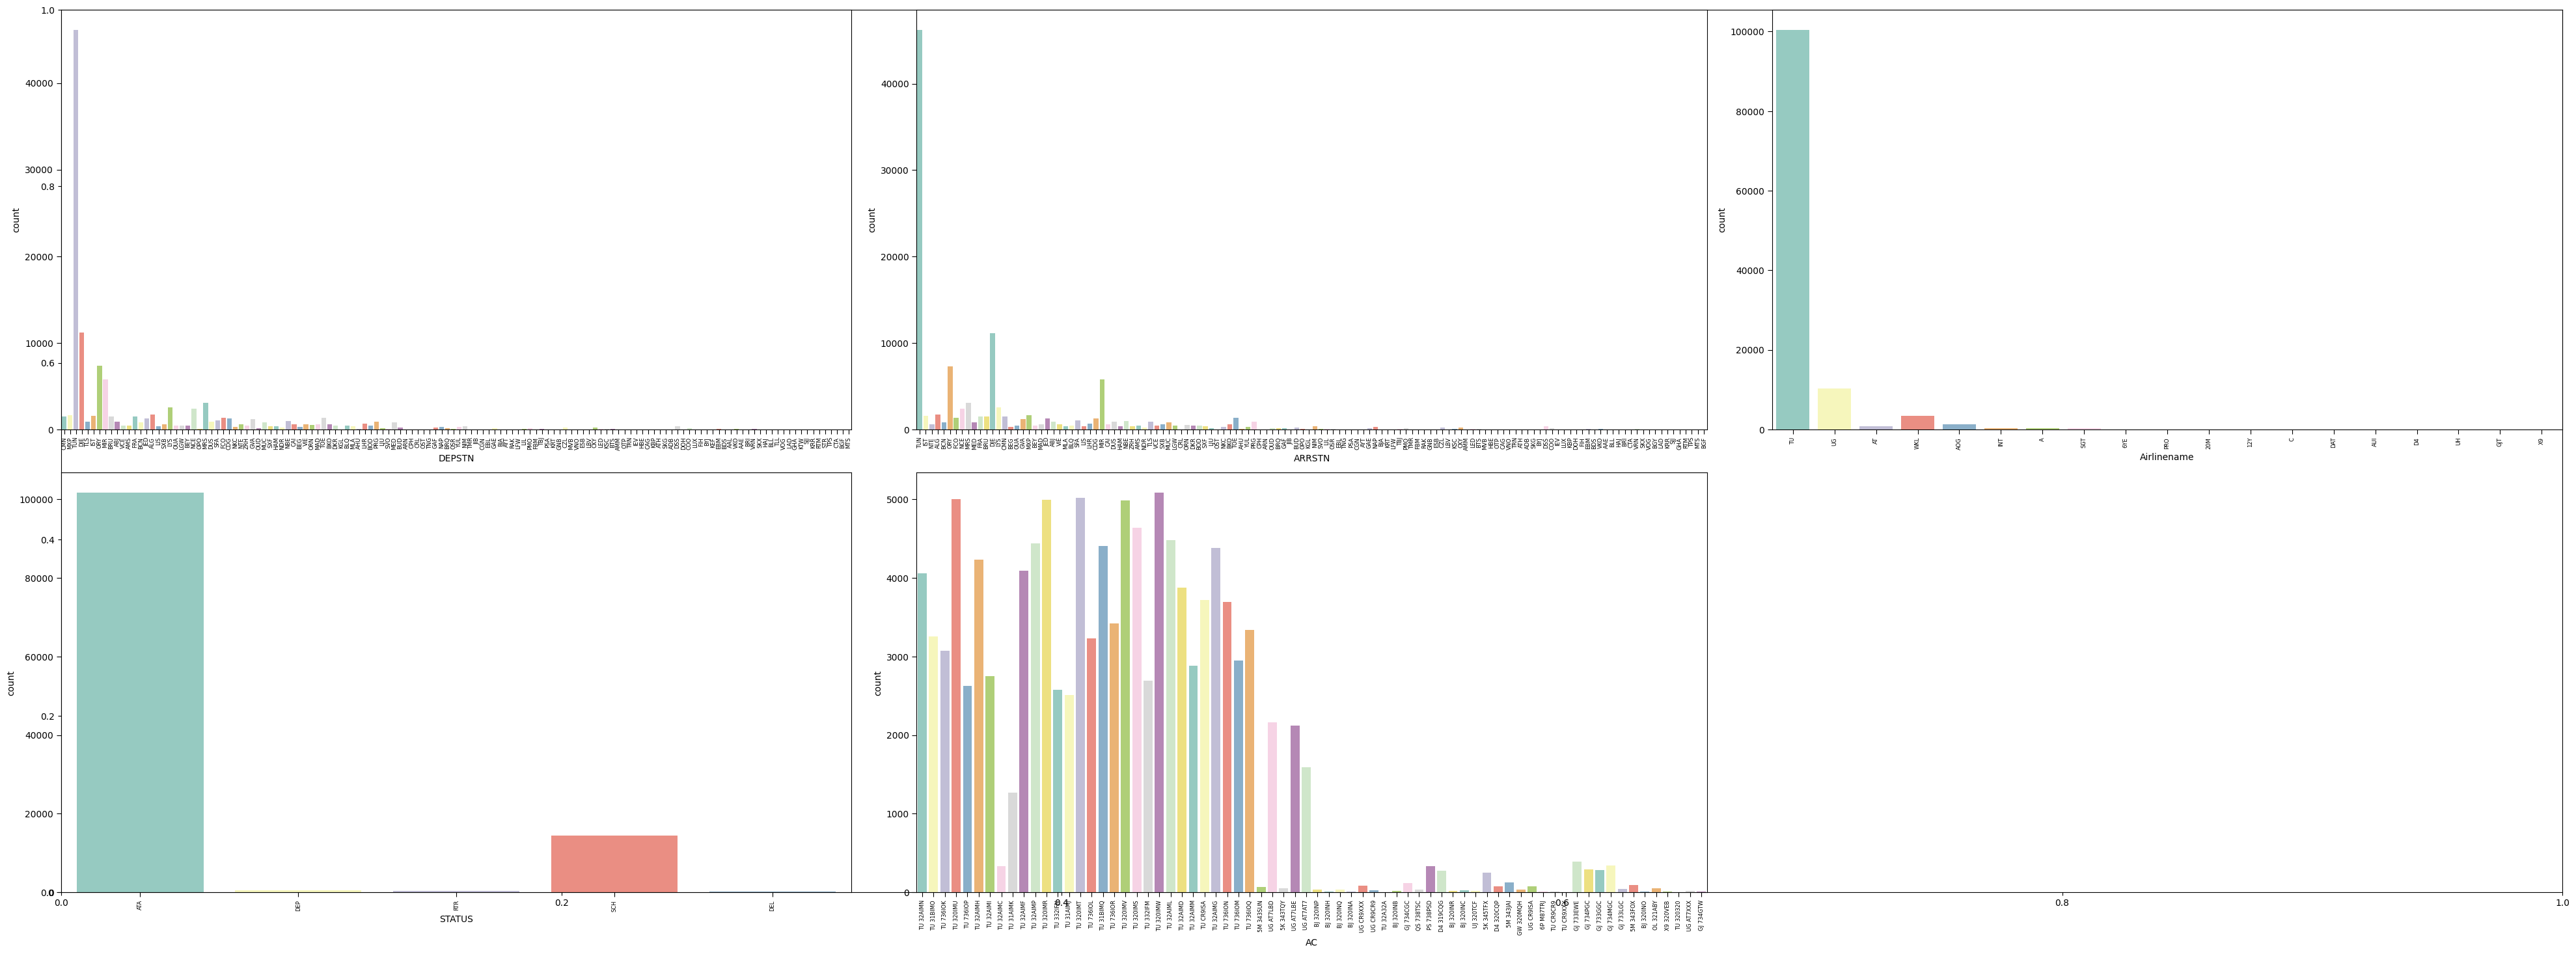

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings


plt.subplots(figsize=(40, 15))

# Define the list of columns to visualize
sample = ['DEPSTN', 'ARRSTN', 'Airlinename', 'STATUS', 'AC']

# Loop through the specified columns
for i, col in enumerate(sample):
    # Create subplots in a 3x2 grid
    plt.subplot(2, 3, i + 1)
    
    # Create a countplot for the current column with a unique color for each bar
    sns.countplot(data=combined_data, x=col, palette='Set3')
    
    # Rotate x-ticks and adjust font size for better visibility
    plt.xticks(rotation=90, fontsize=6)
    plt.tick_params(axis='x', which='both', length=5)
    plt.tick_params(axis='y', which='both', length=5)
    
# Adjust subplot layout for better presentation
plt.tight_layout()

# Display the subplots
plt.show()


In [53]:
combined_data.columns

Index(['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC',
       'Duration', 'Dep_hour', 'Dep_minute', 'Dep_day', 'Dep_month',
       'Dep_year', 'Arr_hour', 'Arr_minute', 'Arr_day', 'Arr_month',
       'Arr_year', 'Day_of_year', 'D_Day', 'D_Day_of_week', 'D_month',
       'D_year', 'Airlinename'],
      dtype='object')

### Visualizing numerical columns

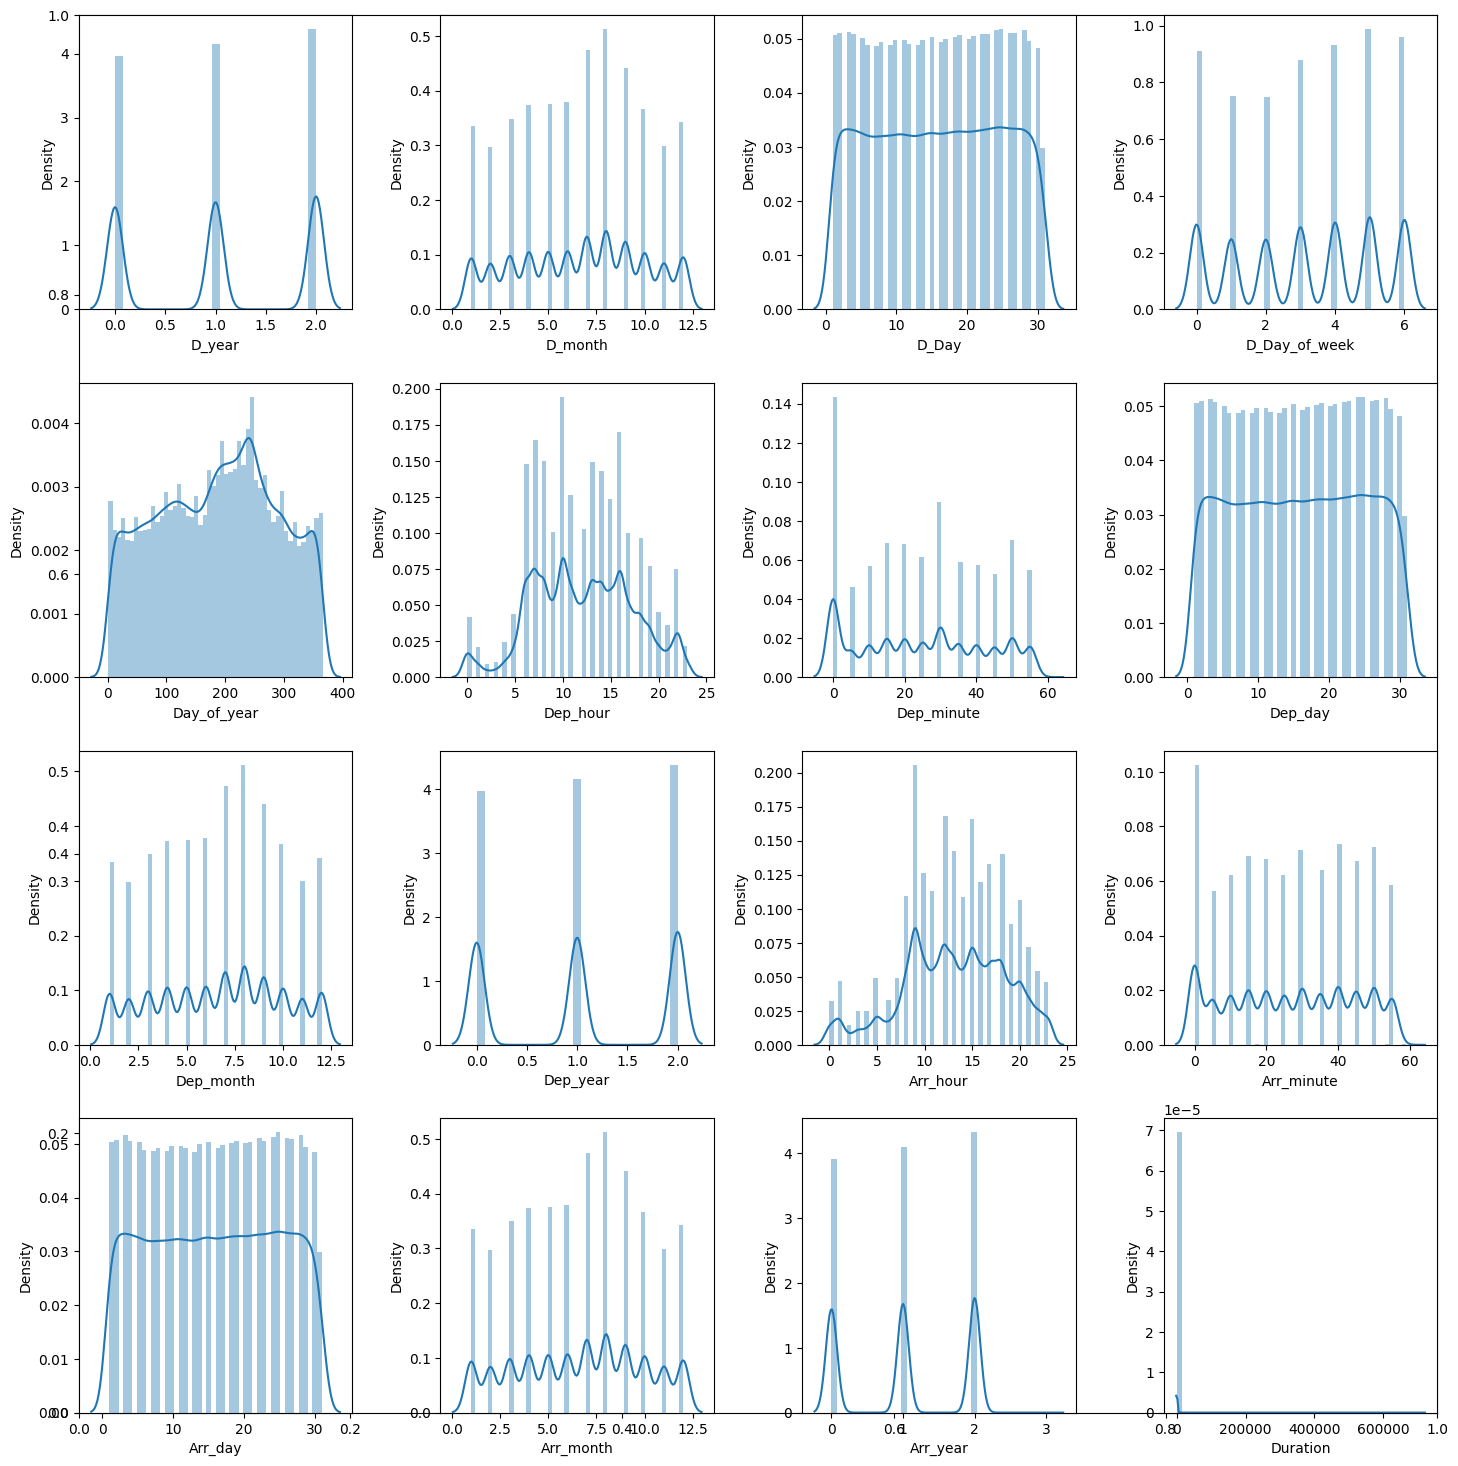

In [59]:
# Set the figure size for the subplots 
plt.subplots(figsize=(15, 15)) 

# Define the list of numeric columns to visualize 
sample = ['D_year', 'D_month', 'D_Day', 'D_Day_of_week',
       'Day_of_year','Dep_hour', 'Dep_minute', 'Dep_day','Dep_month','Dep_year',
       'Arr_hour', 'Arr_minute', 'Arr_day','Arr_month','Arr_year', 'Duration'] 

# Loop through the specified columns 
for i, col in enumerate(sample): 
	# Create subplots in a 4x4 grid 
	plt.subplot(4, 4, i + 1) 
	
	# Create a distribution plot for the current numeric column 
	sns.distplot(combined_data[col]) 
	
# Adjust subplot layout for better presentation 
plt.tight_layout() 

# Display the subplots 
plt.show() 


### Encoding the categorical variables

In [60]:
combined_data.columns

Index(['DATOP', 'FLTID', 'STD', 'STA', 'AC', 'Duration', 'Dep_hour',
       'Dep_minute', 'Dep_day', 'Dep_month',
       ...
       'ARRSTN_TRN', 'ARRSTN_TUN', 'ARRSTN_VCE', 'ARRSTN_VIE', 'ARRSTN_VKO',
       'ARRSTN_VNO', 'ARRSTN_VOG', 'ARRSTN_VRN', 'ARRSTN_YUL', 'ARRSTN_ZRH'],
      dtype='object', length=291)

In [61]:
#Label Encoding 
col=['FLTID','Airlinename','AC','D_year','Dep_year','Arr_year']
labelencoder = LabelEncoder()
for i in col:
    combined_data[i] = labelencoder.fit_transform(combined_data[i])

In [ ]:
#One_hot_encoding
# One-hot encode categorical columns
combined_data = pd.get_dummies(combined_data, columns=['STATUS','DEPSTN','ARRSTN'])

# Display the encoded trainFrame
combined_data.head()

In [63]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117166 entries, 0 to 117165
Columns: 291 entries, DATOP to ARRSTN_ZRH
dtypes: bool(269), datetime64[ns](3), float64(1), int32(12), int64(6)
memory usage: 44.4 MB


In [64]:
combined_data = combined_data.drop(columns=['DATOP','STD','STA'])

In [65]:
#SLICING THE DATASET
train_data = combined_data[:len(train)]
test_data = combined_data[len(train):]

In [66]:
#adding back the target to the column
train_data['target'] = train_target

In [67]:
train_data.columns

Index(['FLTID', 'AC', 'Duration', 'Dep_hour', 'Dep_minute', 'Dep_day',
       'Dep_month', 'Dep_year', 'Arr_hour', 'Arr_minute',
       ...
       'ARRSTN_TUN', 'ARRSTN_VCE', 'ARRSTN_VIE', 'ARRSTN_VKO', 'ARRSTN_VNO',
       'ARRSTN_VOG', 'ARRSTN_VRN', 'ARRSTN_YUL', 'ARRSTN_ZRH', 'target'],
      dtype='object', length=289)

###MODEL

In [68]:
X = train_data.drop(columns=['target'])
y = train_data['target']

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Columns: 288 entries, FLTID to ARRSTN_ZRH
dtypes: bool(269), float64(1), int32(12), int64(6)
memory usage: 38.4 MB


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your pandas code here

# Reset warnings to default behavior (optional)
#warnings.resetwarnings()


In [72]:
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor(enable_categorical=True)
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [0.025], #so called `eta` value
              'max_depth': [7,8],
              'min_child_weight': [4],
              'subsample': [0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [200,300],
               'silent':[1],
                'nthread': [4]}

xgb_grid = GridSearchCV(xgb_model,parameters,cv = 5,verbose=True,scoring='neg_mean_squared_error')
xgb_grid.fit(X,y)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 300, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.9}


In [73]:
# Get the best estimator
best_model = xgb_grid.best_estimator_

predictions = best_model.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 98.53130079446038


In [74]:
param= {'colsample_bytree': 0.7, 'learning_rate': 0.025, 'max_depth': 8,
        'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4,
        'objective': 'reg:linear', 'silent': 1, 'subsample': 0.9}
xgb_other = XGBRegressor(**param,enable_categorical=True)
xgb_other.fit(X,y)
pred = xgb_other.predict(test_data)


In [75]:
pred

array([23.64676  , 32.317802 , 26.969975 , ...,  7.89676  ,  2.5659976,
       -1.8732512], dtype=float32)

In [76]:
sub1=pd.DataFrame()
sub1['ID'] = submission['ID']
sub1['target'] = pred

In [77]:
sub1.head()

,ID,target
0,test_id_0,23.646761
1,test_id_1,32.317802
2,test_id_2,26.969975
3,test_id_3,15.704450
4,test_id_4,24.500057


In [78]:
sub1['target'] = sub1['target'].round().astype(int)


# Replace any negative values with zero
sub1['target'] = sub1['target'].apply(lambda x: max(0, x))


In [79]:
sub1.to_csv('sub5.csv', index=False)

In [80]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest RMSE: {rmse_rf}')


Random Forest RMSE: 111.67108721166811


In [81]:
import lightgbm as lgb

# Initialize and train the model
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)
lgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f'LightGBM RMSE: {rmse_lgb}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 86266, number of used features: 179
[LightGBM] [Info] Start training from score 48.806216
LightGBM RMSE: 108.03137449526939


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

 

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')

# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred_cbr = model.predict(X_test)

# Evaluate the model
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cbr))
print(f'CatBoost RMSE: {rmse_cb}')


In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and train the model
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_knn = knn_model.predict(X_test_scaled)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print(f'KNN RMSE: {rmse_knn}')


KNN RMSE: 119.52964835903289


In [85]:
from sklearn.linear_model import Lasso

# Initialize and train the model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_lasso = lasso_model.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f'LASSO RMSE: {rmse_lasso}')


LASSO RMSE: 114.24959233889841


In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# Initialize and train the model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(288,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
  ])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
ann_model.compile(optimizer='adam', loss='mean_squared_error')
history = ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping])

# Predictions and evaluation
y_pred_ann = ann_model.predict(X_test_scaled)
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print(f'ANN RMSE: {rmse_ann}')


Epoch 1/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 12381.2090 - val_loss: 13930.0830
Epoch 2/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 12322.6318 - val_loss: 13863.6699
Epoch 3/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 12363.2949 - val_loss: 13769.5439
Epoch 4/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11760.2920 - val_loss: 13685.3438
Epoch 5/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11372.6787 - val_loss: 13704.2227
Epoch 6/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 10965.8047 - val_loss: 13731.5635
Epoch 7/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11257.9893 - val_loss: 13797.8145
Epoch 8/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11325.8350 - val_loss: 13790.5566
Epoch 9/50
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 11744.2236 - val_loss: 13896.3145
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ANN RMSE: 112.98488229028486


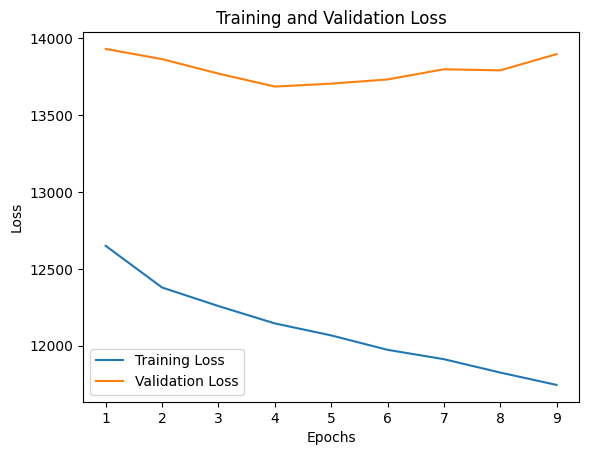

In [89]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [90]:
print(f'XGBoost RMSE: {rmse}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'ANN RMSE: {rmse_ann}')
print(f'KNN RMSE: {rmse_knn}')
print(f'LASSO RMSE: {rmse_lasso}')
print(f'LightGBM RMSE: {rmse_lgb}')
print(f'Catboost RMSE: {rmse_cb}')



XGBoost RMSE: 98.53130079446038
Random Forest RMSE: 111.67108721166811
ANN RMSE: 112.98488229028486
KNN RMSE: 119.52964835903289
LASSO RMSE: 114.24959233889841
LightGBM RMSE: 108.03137449526939
Catboost RMSE: 108.65368900454445


In [ ]:
predict = model.predict(test_data)
predict

In [ ]:
CBR=pd.DataFrame()
CBR['ID'] = submission['ID']
CBR['target'] = predict

In [ ]:
CBR.head()

In [ ]:
CBR['target'] = CBR['target'].round().astype(int)


# Replace any negative values with zero
CBR['target'] = CBR['target'].apply(lambda x: max(0, x))


In [ ]:
CBR

In [ ]:
CBR.to_csv('CBR.csv', index = False)

In [ ]:
prediction = lgb_model.predict(test_data)
prediction

array([37.0117016 , 39.88792136, 31.73856958, ..., -3.77344883,
        0.69971894, -2.29569945])

In [ ]:
df=pd.DataFrame()
df['ID'] = submission['ID']
df['target'] = prediction

In [ ]:
df

,ID,target
0,test_id_0,37.011702
1,test_id_1,39.887921
2,test_id_2,31.738570
3,test_id_3,16.268435
4,test_id_4,26.252086
...,...,...
9328,test_id_9328,202.758206
9329,test_id_9329,32.443706
9330,test_id_9330,-3.773449
9331,test_id_9331,0.699719


In [ ]:
df['target'] = df['target'].round().astype(int)


# Replace any negative values with zero
df['target'] = df['target'].apply(lambda x: max(0, x))


In [ ]:
df

,ID,target
0,test_id_0,37
1,test_id_1,40
2,test_id_2,32
3,test_id_3,16
4,test_id_4,26
...,...,...
9328,test_id_9328,203
9329,test_id_9329,32
9330,test_id_9330,0
9331,test_id_9331,1


In [ ]:
df.to_csv('LGB.csv', index=False)